In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                            roc_curve, auc, f1_score)
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import pickle
import warnings
import time
import os
warnings.filterwarnings('ignore')

# Set TensorFlow warnings to be minimal
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [ ]:
print("1. Loading and exploring data...")
df = pd.read_csv('heart_disease_uci.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Create target variable
df['target'] = df['num'].apply(lambda x: 0 if x == 0 else 1)
print(f"Target distribution: {df['target'].value_counts().to_dict()}")
print(f"Percentage with heart disease: {df['target'].mean()*100:.2f}%")

# Drop unnecessary columns
df = df.drop(['id', 'dataset', 'num'], axis=1)

1. Loading and exploring data...
Dataset shape: (920, 16)
Missing values: 1759
Target distribution: {1: 509, 0: 411}
Percentage with heart disease: 55.33%


In [ ]:
print("\n3. Preparing data for modeling...")

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)
print(f"Features after encoding: {X.shape[1]}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


3. Preparing data for modeling...
Features after encoding: 18
Training set: 736 samples
Testing set: 184 samples



4. Performing feature selection...
Top 15 selected features:
  1. age
  2. trestbps
  3. chol
  4. thalch
  5. exang
  6. oldpeak
  7. ca
  8. sex_Male
  9. cp_atypical angina
  10. cp_non-anginal
  11. restecg_normal
  12. restecg_st-t abnormality
  13. slope_upsloping
  14. thal_normal
  15. thal_reversable defect


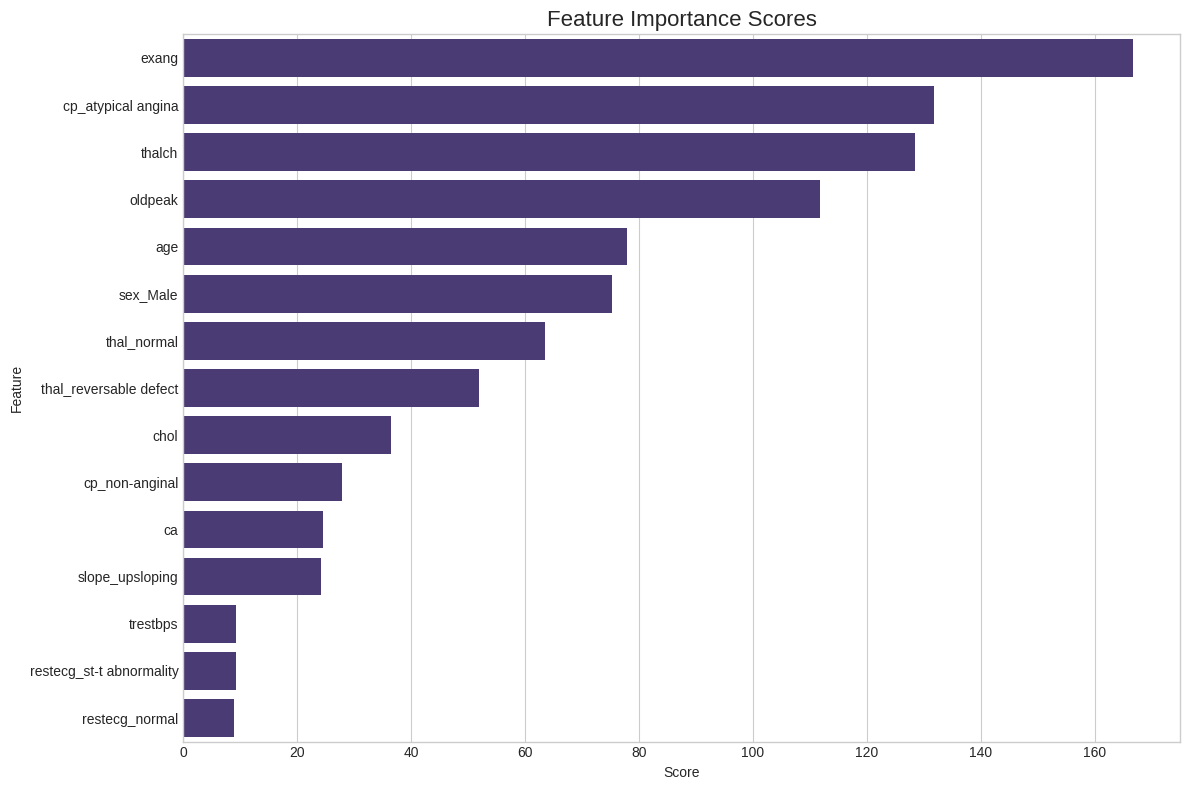

In [ ]:
print("\n4. Performing feature selection...")
selector = SelectKBest(f_classif, k=15)  # Select top 15 features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
feature_indices = selector.get_support(indices=True)
selected_features = X.columns[feature_indices]
print("Top 15 selected features:")
for i, feature in enumerate(selected_features):
    print(f"  {i+1}. {feature}")

# Feature importance visualization
plt.figure(figsize=(12, 8))
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)
sns.barplot(x='Score', y='Feature', data=feature_scores.head(15))
plt.title('Feature Importance Scores', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
print("\n5. Applying SMOTE for class balancing...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)
print(f"Class distribution before SMOTE: {np.bincount(y_train)}")
print(f"Class distribution after SMOTE: {np.bincount(y_train_balanced)}")



5. Applying SMOTE for class balancing...
Class distribution before SMOTE: [329 407]
Class distribution after SMOTE: [407 407]


In [ ]:
print("\n6. Training traditional models with hyperparameter tuning...")

# Define models with hyperparameter grids
models_with_params = {
    "XGBoost": {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'min_child_weight': [1, 3],
            'subsample': [0.8, 1.0],
            'gamma': [0, 0.1]
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 15, 30],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', None]
        }
    },
    "Gradient Boosting": {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    }
}

# Perform hyperparameter search
best_models = {}
cv_results = {}
test_results = {}

for name, model_info in models_with_params.items():
    print(f"\nTuning {name}...")

    # Create 5-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use RandomizedSearchCV for efficient searching
    random_search = RandomizedSearchCV(
        estimator=model_info['model'],
        param_distributions=model_info['params'],
        n_iter=20,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # Fit on the balanced data
    try:
        random_search.fit(X_train_balanced, y_train_balanced)
        best_models[name] = random_search.best_estimator_

        # Log results
        cv_results[name] = {
            'best_params': random_search.best_params_,
            'best_cv_score': random_search.best_score_
        }

        # Evaluate on test data
        y_train_pred = best_models[name].predict(X_train_selected)
        y_test_pred = best_models[name].predict(X_test_selected)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)

        test_results[name] = {'accuracy': test_acc, 'f1': test_f1}

        print(f"  Best parameters: {random_search.best_params_}")
        print(f"  Best CV accuracy: {random_search.best_score_:.4f}")
        print(f"  Test accuracy: {test_acc:.4f}")
        print(f"  Test F1 score: {test_f1:.4f}")

    except Exception as e:
        print(f"Error tuning {name}: {str(e)}")



6. Training traditional models with hyperparameter tuning...

Tuning XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
  Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.1}
  Best CV accuracy: 0.8268
  Test accuracy: 0.8370
  Test F1 score: 0.8544

Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
  Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 30}
  Best CV accuracy: 0.8329
  Test accuracy: 0.8370
  Test F1 score: 0.8571

Tuning Gradient Boosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
  Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01}
  Best CV accuracy: 0.8329
  Test accuracy: 0.8370
  Test F1 score: 0.8500



7. Training neural network model...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6146 - loss: 0.7675 - val_accuracy: 0.7301 - val_loss: 0.6298
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8088 - loss: 0.5003 - val_accuracy: 0.7607 - val_loss: 0.5694
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7738 - loss: 0.5184 - val_accuracy: 0.7485 - val_loss: 0.5384
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8054 - loss: 0.4848 - val_accuracy: 0.7546 - val_loss: 0.5132
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7871 - loss: 0.4531 - val_accuracy: 0.7791 - val_loss: 0.4907
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7892 - loss: 0.4449 - val_accuracy: 0.7914 - val_loss: 0.4683
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8133 - loss: 0.4336 - val_accuracy: 0.7975 - val_loss: 0.4418
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.795

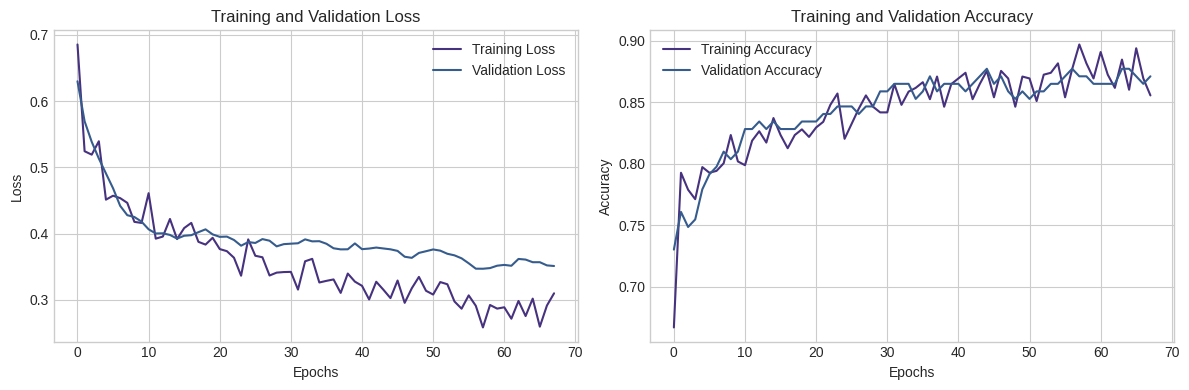

In [ ]:
print("\n7. Training neural network model...")

# Function to create neural network
def create_neural_network():
    model = Sequential([
        # Input layer
        Dense(128, activation='relu', input_shape=(X_train_selected.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        # Hidden layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train neural network
nn_model = create_neural_network()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
try:
    history = nn_model.fit(
        X_train_balanced, y_train_balanced,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate neural network
    y_train_pred_nn = (nn_model.predict(X_train_selected) > 0.5).astype(int).flatten()
    y_test_pred_nn = (nn_model.predict(X_test_selected) > 0.5).astype(int).flatten()

    # Calculate metrics
    train_acc_nn = accuracy_score(y_train, y_train_pred_nn)
    test_acc_nn = accuracy_score(y_test, y_test_pred_nn)
    test_f1_nn = f1_score(y_test, y_test_pred_nn)

    print(f"Neural Network Results:")
    print(f"  Training Accuracy: {train_acc_nn:.4f}")
    print(f"  Testing Accuracy: {test_acc_nn:.4f}")
    print(f"  Testing F1 Score: {test_f1_nn:.4f}")

    # Add to results
    test_results['Neural Network'] = {'accuracy': test_acc_nn, 'f1': test_f1_nn}

    # Create wrapper for neural network to work with ensemble
    class NeuralNetworkWrapper:
        def __init__(self, model):
            self.model = model

        def predict(self, X):
            return (self.model.predict(X) > 0.5).astype(int).flatten()

        def predict_proba(self, X):
            probs = self.model.predict(X).flatten()
            return np.vstack([1-probs, probs]).T

    nn_wrapper = NeuralNetworkWrapper(nn_model)
    best_models['Neural Network'] = nn_wrapper

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error training Neural Network: {str(e)}")


In [ ]:
#==============================================
# 8. Ensemble Model (FIXED)
#==============================================
print("\n8. Creating ensemble model...")

# Create ensemble with only traditional models (exclude Neural Network)
estimators = [(name, model) for name, model in best_models.items()
              if name != 'Neural Network']

# Check if we have enough models for an ensemble
if len(estimators) > 1:
    # Create and train ensemble
    ensemble = VotingClassifier(estimators=estimators, voting='soft')
    ensemble.fit(X_train_balanced, y_train_balanced)

    # Evaluate ensemble
    y_train_pred_ensemble = ensemble.predict(X_train_selected)
    y_test_pred_ensemble = ensemble.predict(X_test_selected)

    # Calculate metrics
    train_acc_ens = accuracy_score(y_train, y_train_pred_ensemble)
    test_acc_ens = accuracy_score(y_test, y_test_pred_ensemble)
    test_f1_ens = f1_score(y_test, y_test_pred_ensemble)

    print(f"Ensemble Model Results:")
    print(f"  Training Accuracy: {train_acc_ens:.4f}")
    print(f"  Testing Accuracy: {test_acc_ens:.4f}")
    print(f"  Testing F1 Score: {test_f1_ens:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_test_pred_ensemble))

    # Add ensemble to results
    test_results['Ensemble'] = {'accuracy': test_acc_ens, 'f1': test_f1_ens}
    best_models['Ensemble'] = ensemble
else:
    print("Not enough traditional models to create an ensemble")

# Create a custom ensemble that includes neural network predictions
print("\n9. Creating custom ensemble with Neural Network...")

# Function to make predictions using all models (including neural network)
def custom_ensemble_predict(X_data):
    """Combine predictions from all models including neural network"""
    predictions = []
    weights = []

    # Get predictions from traditional models
    for name, model in best_models.items():
        if name != 'Neural Network' and name != 'Ensemble':
            try:
                pred_proba = model.predict_proba(X_data)[:, 1]
                predictions.append(pred_proba)
                # Use model accuracy as weight
                weights.append(test_results[name]['accuracy'])
            except:
                pass

    # Get neural network prediction if available
    if 'Neural Network' in test_results:
        try:
            nn_proba = nn_model.predict(X_data).flatten()
            predictions.append(nn_proba)
            weights.append(test_results['Neural Network']['accuracy'])
        except:
            pass

    # Weight the predictions
    if predictions:
        weights = np.array(weights) / sum(weights)  # Normalize weights
        weighted_preds = np.zeros_like(predictions[0])

        for i, pred in enumerate(predictions):
            weighted_preds += pred * weights[i]

        # Return binary predictions
        return (weighted_preds > 0.5).astype(int), weighted_preds
    else:
        return None, None

# Evaluate custom ensemble
y_test_pred_custom, y_test_proba_custom = custom_ensemble_predict(X_test_selected)

if y_test_pred_custom is not None:
    test_acc_custom = accuracy_score(y_test, y_test_pred_custom)
    test_f1_custom = f1_score(y_test, y_test_pred_custom)

    print(f"Custom Ensemble (with Neural Network) Results:")
    print(f"  Testing Accuracy: {test_acc_custom:.4f}")
    print(f"  Testing F1 Score: {test_f1_custom:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_test_pred_custom))

    # Add to results
    test_results['Custom Ensemble'] = {'accuracy': test_acc_custom, 'f1': test_f1_custom}

    # If custom ensemble is better, update best model info
    if test_acc_custom > max(test_results[m]['accuracy'] for m in test_results if m != 'Custom Ensemble'):
        print("\nCustom ensemble is the best model!")
        best_model_name = 'Custom Ensemble'
        best_metrics = {'accuracy': test_acc_custom, 'f1': test_f1_custom}


8. Creating ensemble model...


ValueError: The estimator NeuralNetworkWrapper should be a classifier.